### LeNet网络实现图片分类

<img src="imgs/LeNet.png">

In [6]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), stride=2, kernel_size=(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), stride=2, kernel_size=(2,2))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = LeNet()
print(net)
        

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
print(net.named_parameters)

<bound method Module.named_parameters of LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>


In [9]:
for name, para in net.named_parameters():
    print(name,para)

conv1.weight Parameter containing:
tensor([[[[ 0.0180, -0.0530, -0.1033, -0.0073, -0.0385],
          [-0.0364,  0.0389, -0.0279, -0.0031, -0.0608],
          [ 0.0503, -0.1143,  0.0597,  0.0833,  0.0973],
          [-0.1120, -0.1028,  0.0401, -0.0595,  0.0539],
          [-0.0827, -0.0584,  0.0782,  0.0694, -0.0106]],

         [[-0.0450, -0.0795, -0.0757, -0.0878, -0.1066],
          [-0.0778,  0.0154, -0.0558,  0.0851, -0.0977],
          [ 0.0092,  0.0741, -0.0158, -0.0725,  0.0719],
          [-0.0931, -0.1132,  0.0855, -0.1131,  0.0002],
          [ 0.0541,  0.1028, -0.0515,  0.0938,  0.0706]],

         [[ 0.0240, -0.0434,  0.0832, -0.1027, -0.0760],
          [ 0.0228,  0.1040,  0.0469,  0.1153,  0.0841],
          [-0.0012,  0.0010,  0.0796,  0.0957,  0.0036],
          [ 0.1137, -0.0104, -0.0461, -0.1024,  0.0113],
          [ 0.1045,  0.0862,  0.0444,  0.0123, -0.0001]]],


        [[[ 0.0233,  0.0141, -0.0761, -0.0976,  0.0588],
          [ 0.0584, -0.0562,  0.0120, -0.0865

In [10]:
show = ToPILImage()

In [11]:
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
])
    
# 训练集
trainset = tv.datasets.CIFAR10(
                    root='datasets', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=8,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    'datasets',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=8, 
                    shuffle=False,
                    num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


        car       plane       horse       truck       truck        frog         car        frog


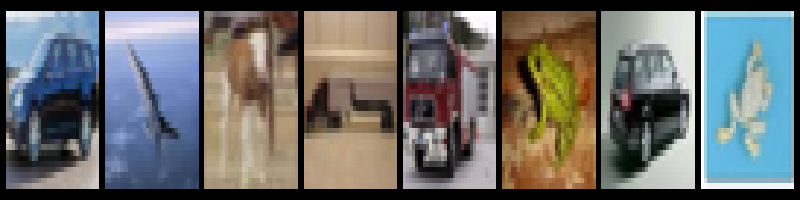

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(8)))
show(tv.utils.make_grid((images+1)/2)).resize((800,200))

In [13]:

criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
net.to(device)

t.set_num_threads(8)
for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print(loss)
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

tensor(2.0068, device='cuda:0', grad_fn=<NllLossBackward>)
[1,  2000] loss: 2.208
tensor(1.6401, device='cuda:0', grad_fn=<NllLossBackward>)
[1,  4000] loss: 1.824
tensor(1.7583, device='cuda:0', grad_fn=<NllLossBackward>)
[1,  6000] loss: 1.623
tensor(1.5512, device='cuda:0', grad_fn=<NllLossBackward>)
[2,  2000] loss: 1.493
tensor(1.1220, device='cuda:0', grad_fn=<NllLossBackward>)
[2,  4000] loss: 1.435
tensor(1.1484, device='cuda:0', grad_fn=<NllLossBackward>)
[2,  6000] loss: 1.371
Finished Training


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
images = images.to(device)
labels = labels.to(device)
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(8)))

预测结果:   bird  ship  ship  ship  deer  frog   car  bird


In [19]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 52 %
